In [16]:
# goal of this notebook:
# train several machine learning models to predict when deepface makes race classification errors better than my first attempt
# using the new dataset that includes both my initial ML features and the embeddings
# i hope this will give better result than in notebook 05 

In [20]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

root = os.path.abspath("..")

train_path = os.path.join(root, "data", "ml_final", "train_ml_final.parquet")
val_path   = os.path.join(root, "data", "ml_final", "val_ml_final.parquet")

print(train_path)
print(val_path)
# setting up imports and loading the finals datasets

/Users/leobideau/Desktop/fairface-project/data/ml_final/train_ml_final.parquet
/Users/leobideau/Desktop/fairface-project/data/ml_final/val_ml_final.parquet


In [21]:
train = pd.read_parquet(train_path)
val   = pd.read_parquet(val_path)

print(train.shape, val.shape)
train.head()
# loading ml_final datasets created in 04BIS

(7000, 524) (2100, 524)


,pred_gender,pred_gender_score,pred_race,pred_race_score,error,file,race_true,gender_true,img_path,brightness,...,emb_502,emb_503,emb_504,emb_505,emb_506,emb_507,emb_508,emb_509,emb_510,emb_511
0,Woman,88.418669,black,43.714210,None,train/60423.jpg,Black,Female,../data/processed/balanced_images/train/60423.jpg,48.987080,...,-0.383360,0.310170,-1.224776,0.447964,0.245348,0.083696,-0.843259,0.022875,0.841157,0.046678
1,Man,97.433734,black,78.286773,None,train/45029.jpg,Black,Female,../data/processed/balanced_images/train/45029.jpg,141.144018,...,-0.610930,-0.407818,0.366365,0.419494,-1.338491,0.949222,-0.272494,0.577557,2.479701,-0.574154
2,Woman,99.483669,latino hispanic,41.124514,None,train/81730.jpg,Black,Female,../data/processed/balanced_images/train/81730.jpg,32.576097,...,-0.111480,0.934989,-0.916757,0.991272,0.842678,0.484414,0.006311,-0.357479,-0.067248,0.240468
3,Man,89.559507,indian,58.377320,None,train/72069.jpg,Black,Female,../data/processed/balanced_images/train/72069.jpg,106.053985,...,-0.538655,-0.026991,-0.150060,0.868620,0.127137,-0.058055,-0.148640,-0.224628,0.565578,0.105068
4,Man,64.608073,black,34.814405,None,train/37655.jpg,Black,Female,../data/processed/balanced_images/train/37655.jpg,55.268659,...,-0.441455,0.952773,-1.095437,0.918637,0.361822,-0.097846,-0.071504,-0.272044,0.446135,-0.287135


In [22]:
train["race_true_clean"] = train["race_true"].str.lower().str.replace("_", " ")
train["pred_race_clean"] = train["pred_race"].str.lower()

val["race_true_clean"] = val["race_true"].str.lower().str.replace("_", " ")
val["pred_race_clean"] = val["pred_race"].str.lower()

y_train = (train["race_true_clean"] != train["pred_race_clean"]).astype(int)
y_val   = (val["race_true_clean"]   != val["pred_race_clean"]).astype(int)

print("class balance train:", np.bincount(y_train))
print("class balance val:", np.bincount(y_val))
# target = 1 when deepface is wrong nd 0 otherwise

class balance train: [2440 4560]
class balance val: [ 698 1402]


In [23]:
X_train = train.select_dtypes(include=[np.number])
X_val   = val.select_dtypes(include=[np.number])

print("train feature shape:", X_train.shape)
print("val feature shape:", X_val.shape)
# isolating the real ML features: the embeddings nd the numeric scores so the models train on actual signals

train feature shape: (7000, 517)
val feature shape: (2100, 517)


In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
# scaling numeric features for models

In [25]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report
)

def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))

    try:
        print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    except:
        print("ROC-AUC: undefined (model predicted only one class)")

    print("\nClassification Report:\n", classification_report(y_true, y_pred))
 # same than in nb 05 but i added for safety that ROC-AUC can fail if only one class is predicted

In [26]:
# majority-class baseline for comparison:

In [27]:
baseline_pred = np.ones(len(y_val))
baseline_acc  = accuracy_score(y_val, baseline_pred)

print("baseline accuracy (always error):", baseline_acc)
naive_accuracy = baseline_acc

baseline accuracy (always error): 0.6676190476190477


In [28]:
# logistic regression:

logistic accuracy: 0.7409523809523809
Accuracy: 0.7409523809523809
F1-score: 0.8159675236806495
Precision: 0.7760617760617761
Recall: 0.8601997146932953
ROC-AUC: 0.6808161897248711

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56       698
           1       0.78      0.86      0.82      1402

    accuracy                           0.74      2100
   macro avg       0.71      0.68      0.69      2100
weighted avg       0.73      0.74      0.73      2100



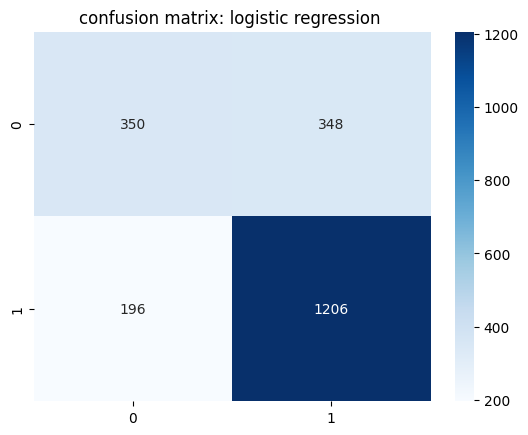

In [29]:
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_scaled, y_train)

log_pred = log_model.predict(X_val_scaled)
log_acc  = accuracy_score(y_val, log_pred)

print("logistic accuracy:", log_acc)
evaluate_model(y_val, log_pred)

cm = confusion_matrix(y_val, log_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: logistic regression ")
plt.show()

In [12]:
# embeddings massively improve the model
# accuracy goes from 0.667 to 0.7409 and global F1 also increases
# most importantly, the model learns to detect the minority class: F1 for class 0 jumps from 0.01 to 0.56
# embeddings give the model a clear and useful signal instead of weak basic features

In [13]:
# Knn:


knn (k=3)

accuracy: 0.680952380952381
F1-score: 0.7696011004126547
precision: 0.7430278884462151
recall: 0.7981455064194009
roc-auc: 0.6218521228372076

classification report:

              precision    recall  f1-score   support

           0       0.52      0.45      0.48       698
           1       0.74      0.80      0.77      1402

    accuracy                           0.68      2100
   macro avg       0.63      0.62      0.63      2100
weighted avg       0.67      0.68      0.67      2100



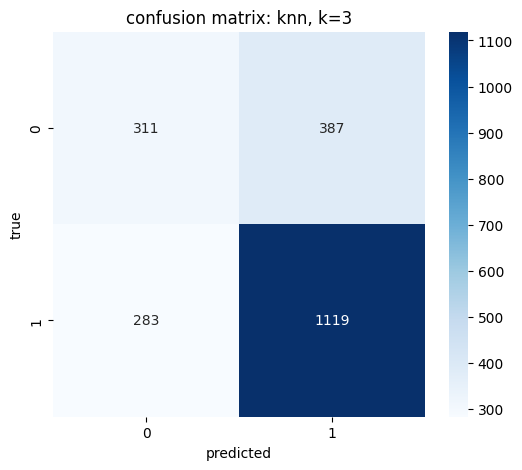


knn (k=5)

accuracy: 0.6976190476190476
F1-score: 0.7871270533020449
precision: 0.7425679949399114
recall: 0.8373751783166904
roc-auc: 0.6271403112213825

classification report:

              precision    recall  f1-score   support

           0       0.56      0.42      0.48       698
           1       0.74      0.84      0.79      1402

    accuracy                           0.70      2100
   macro avg       0.65      0.63      0.63      2100
weighted avg       0.68      0.70      0.68      2100



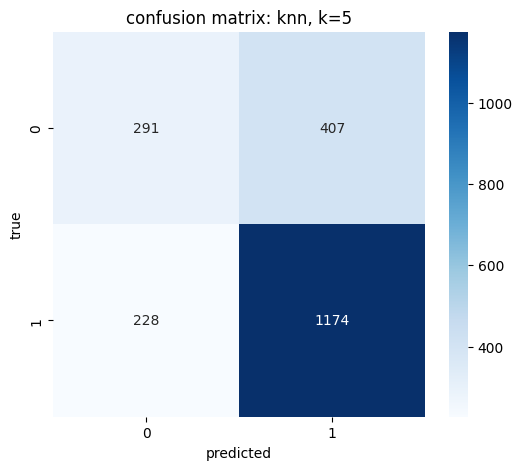


knn (k=7)

accuracy: 0.7095238095238096
F1-score: 0.7988126649076517
precision: 0.7429447852760737
recall: 0.8637660485021398
roc-auc: 0.6317397577754251

classification report:

              precision    recall  f1-score   support

           0       0.59      0.40      0.48       698
           1       0.74      0.86      0.80      1402

    accuracy                           0.71      2100
   macro avg       0.67      0.63      0.64      2100
weighted avg       0.69      0.71      0.69      2100



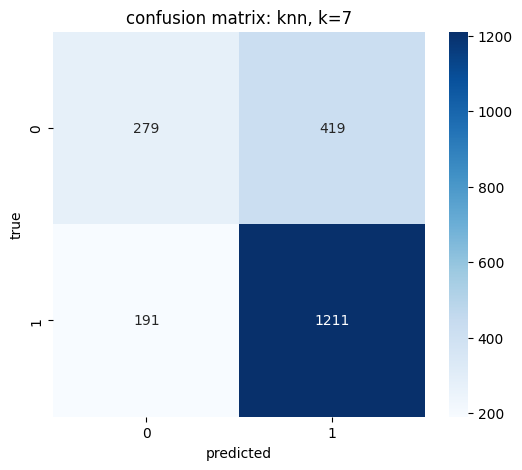

In [34]:
knn_results = {}

for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    pred = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, pred)
    f1  = f1_score(y_val, pred, zero_division=0)
    prec = precision_score(y_val, pred, zero_division=0)
    rec  = recall_score(y_val, pred, zero_division=0)
    auc  = roc_auc_score(y_val, pred)
    
    knn_results[k] = {
        "pred": pred,
        "acc": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": auc
    }

    print(f"\nknn (k={k})\n")
    print("accuracy:", acc)
    print("F1-score:", f1)
    print("precision:", prec)
    print("recall:", rec)
    print("roc-auc:", auc)

    print("\nclassification report:\n")
    print(classification_report(y_val, pred))

    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.title(f"confusion matrix: knn, k={k}")
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()

In [15]:
# embeddings improve Knn nd accuracy increases for every k:
# k=3 goes from 0.58 to 0.68 
# k=5 from 0.59 to 0.697 
# k=7 from 0.603 to 0.709

# F1-score for the minority class also improves from ~ 0.30 to ~ 0.48 across all k
# confusion matrices show fewer false positives and more balanced behaviour instead of always predicting class 1

# distances become more meaningful thanks to the 512 dimensional embeddings

In [16]:
# randomforest:

random forest accuracy: 0.7385714285714285
Accuracy: 0.7385714285714285
F1-score: 0.8183923255044657
Precision: 0.7631091918568784
Recall: 0.8823109843081313
ROC-AUC: 0.6660838589162432

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.45      0.53       698
           1       0.76      0.88      0.82      1402

    accuracy                           0.74      2100
   macro avg       0.71      0.67      0.68      2100
weighted avg       0.73      0.74      0.72      2100



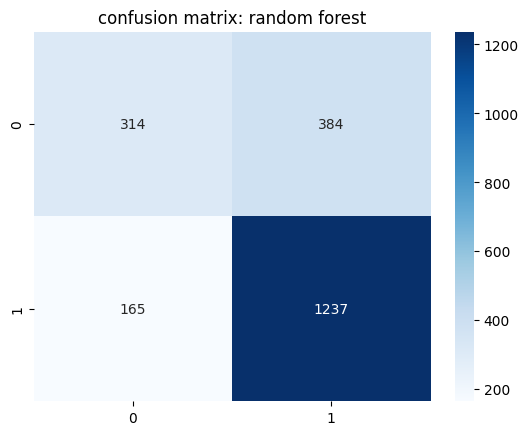

In [32]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_val_scaled)
rf_acc  = accuracy_score(y_val, rf_pred)

print("random forest accuracy:", rf_acc)
evaluate_model(y_val, rf_pred)

cm = confusion_matrix(y_val, rf_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: random forest")
plt.show()

In [18]:
# embeddings makes random forest go from 0.6748 to 0.7386
# the trees benefit from the high dimensional embedding space

# minority-class (correct predictions = class 0) F1 jumps from 0.31 to 0.53
# precision nd recall also improve for both classes
# confusion matrix shows more true 0 are recovered 152 to 314

# overall: embeddings give the trees real structure to learn from

In [19]:
# support vector machine -> SVM :


svm (linear)

accuracy: 0.758095238095238
f1-score: 0.8307794803464357
precision: 0.779375
recall: 0.8894436519258203
roc-auc: 0.6918564964500162

classification report:

              precision    recall  f1-score   support

           0       0.69      0.49      0.58       698
           1       0.78      0.89      0.83      1402

    accuracy                           0.76      2100
   macro avg       0.73      0.69      0.70      2100
weighted avg       0.75      0.76      0.75      2100



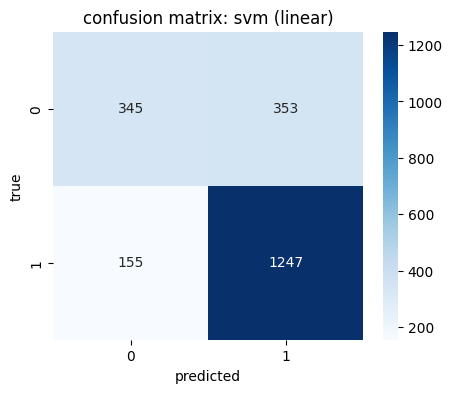


svm (rbf)

accuracy: 0.7347619047619047
f1-score: 0.8111224143777551
precision: 0.773109243697479
recall: 0.8530670470756063
roc-auc: 0.6751008587813562

classification report:

              precision    recall  f1-score   support

           0       0.63      0.50      0.55       698
           1       0.77      0.85      0.81      1402

    accuracy                           0.73      2100
   macro avg       0.70      0.68      0.68      2100
weighted avg       0.72      0.73      0.73      2100



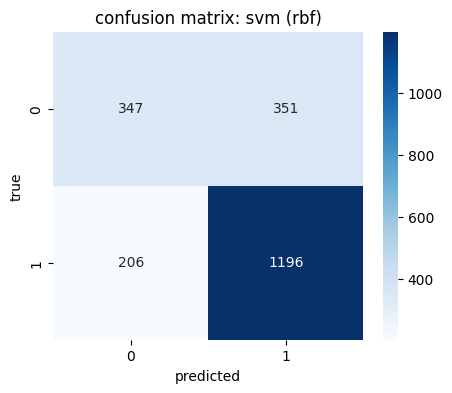

In [30]:
kernels = {
    "svm (linear)": SVC(kernel="linear", random_state=42),
    "svm (rbf)": SVC(kernel="rbf", C=2, gamma="scale", random_state=42)
}

svm_results = {}

for name, model in kernels.items():

    print(f"\n{name}\n")

    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_val_scaled)

    acc  = accuracy_score(y_val, pred)
    f1   = f1_score(y_val, pred)
    prec = precision_score(y_val, pred)
    rec  = recall_score(y_val, pred)
    auc  = roc_auc_score(y_val, pred)

    svm_results[name] = {
        "acc": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec,
        "roc_auc": auc,
        "pred": pred
    }

    print("accuracy:", acc)
    print("f1-score:", f1)
    print("precision:", prec)
    print("recall:", rec)
    print("roc-auc:", auc)
    print("\nclassification report:\n")
    print(classification_report(y_val, pred))

    cm = confusion_matrix(y_val, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"confusion matrix: {name}")
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()

In [21]:
# embeddings improve Svm rbf from 0.667 to 0.7347 accuracy and F1 from 0.06 to 0.55
# linear SVM stops collapsing before 4it was only class 1 -> now 0.76 acc and real F1 = 0.58
# both models finally learn class 0 instead of ignoring it

In [22]:
# results embedding :

In [35]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

log_f1        = f1_score(y_val, log_pred)
log_precision = precision_score(y_val, log_pred)
log_recall    = recall_score(y_val, log_pred)
log_roc_auc   = roc_auc_score(y_val, log_pred)

rf_f1        = f1_score(y_val, rf_pred)
rf_precision = precision_score(y_val, rf_pred)
rf_recall    = recall_score(y_val, rf_pred)
rf_roc_auc   = roc_auc_score(y_val, rf_pred)

naive_accuracy = baseline_acc
naive_f1 = 0.0
naive_precision = 0.0
naive_recall = 1.0
naive_roc_auc = 0.5

df_results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "KNN (k=3)",
        "KNN (k=5)",
        "KNN (k=7)",
        "Random Forest",
        "SVM (linear)",
        "SVM (RBF)",
        "Baseline (always error)"
    ],
    "Accuracy": [
        log_acc,
        knn_results[3]["acc"],
        knn_results[5]["acc"],
        knn_results[7]["acc"],
        rf_acc,
        svm_results["svm (linear)"]["acc"],
        svm_results["svm (rbf)"]["acc"],
        naive_accuracy
    ],
    "F1-score": [
        log_f1,
        knn_results[3]["f1"],
        knn_results[5]["f1"],
        knn_results[7]["f1"],
        rf_f1,
        svm_results["svm (linear)"]["f1"],
        svm_results["svm (rbf)"]["f1"],
        naive_f1
    ],
    "Precision": [
        log_precision,
        knn_results[3]["precision"],
        knn_results[5]["precision"],
        knn_results[7]["precision"],
        rf_precision,
        svm_results["svm (linear)"]["precision"],
        svm_results["svm (rbf)"]["precision"],
        naive_precision
    ],
    "Recall": [
        log_recall,
        knn_results[3]["recall"],
        knn_results[5]["recall"],
        knn_results[7]["recall"],
        rf_recall,
        svm_results["svm (linear)"]["recall"],
        svm_results["svm (rbf)"]["recall"],
        naive_recall
    ],
    "ROC-AUC": [
        log_roc_auc,
        knn_results[3]["roc_auc"],
        knn_results[5]["roc_auc"],
        knn_results[7]["roc_auc"],
        rf_roc_auc,
        svm_results["svm (linear)"]["roc_auc"],
        svm_results["svm (rbf)"]["roc_auc"],
        naive_roc_auc
    ]
})

df_results = df_results.round(4)
df_results

,Model,Accuracy,F1-score,Precision,Recall,ROC-AUC
0,Logistic Regression,0.7410,0.8160,0.7761,0.8602,0.6808
1,KNN (k=3),0.6810,0.7696,0.7430,0.7981,0.6219
2,KNN (k=5),0.6976,0.7871,0.7426,0.8374,0.6271
3,KNN (k=7),0.7095,0.7988,0.7429,0.8638,0.6317
4,Random Forest,0.7386,0.8184,0.7631,0.8823,0.6661
5,SVM (linear),0.7581,0.8308,0.7794,0.8894,0.6919
6,SVM (RBF),0.7348,0.8111,0.7731,0.8531,0.6751
7,Baseline (always error),0.6676,0.0000,0.0000,1.0000,0.5000


In [24]:
# conclusion:
# in notebook 05, all models were trained only on the raw features scores, brightness, contrast, saturation
# and they all stayed close to the baseline: 0.667

# with the 512 dimensional embeddings, every model learns real structure and performance increases across the board

# svm (linear) becomes the best model with 0.758 accuracy and 0.83 f1
# random forest and logistic regression also improve a lot thanks to the embeddings
# knn models get better from k=3 to k=7 but still stay behind the others
# the baseline stays at 0.667, showing that accuracy alone is misleading on this imbalanced dataset

# overall: embeddings change a lot
# without them the models basically learn nothing
# with them multiple models can finally predict when deepface will make an error
# however i feel that the gains are still limited so ill try to tuning to achieve better performance

In [25]:
# tuning  :
# at first I tuned on accuracy but switched to F1 because the dataset is imbalanced 
# and accuracy was rewarding models that ignored class 0 while F1 will forces the model to perform well on both classes

In [36]:
train["target"] = (train["race_true_clean"] != train["pred_race_clean"]).astype(int)
val["target"]   = (val["race_true_clean"] != val["pred_race_clean"]).astype(int)

print(train["target"].value_counts())
print(val["target"].value_counts())
# target rebuilt from scratch so ML models can predict deepface errors.

target
1    4560
0    2440
Name: count, dtype: int64
target
1    1402
0     698
Name: count, dtype: int64


In [37]:
import numpy as np
from sklearn.preprocessing import StandardScaler

emb_cols = [c for c in train.columns if c.startswith("emb_")]

feature_cols = [
    "pred_gender_score",
    "pred_race_score",
    "brightness",
    "contrast",
    "saturation"
]
scaler = StandardScaler()
train_emb_scaled = scaler.fit_transform(train[emb_cols])
val_emb_scaled   = scaler.transform(val[emb_cols])

train_num = train[feature_cols].values
val_num   = val[feature_cols].values

X_train = np.hstack([train_emb_scaled, train_num])
X_val   = np.hstack([val_emb_scaled, val_num])

y_train = train["target"].values
y_val   = val["target"].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
# preprocessing 

X_train shape: (7000, 517)
X_val shape: (2100, 517)


In [28]:
# logistic regression tuned :

best logistic params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy: 0.7414285714285714
f1-score: 0.8164920581277458
precision: 0.7758509955041747
recall: 0.8616262482168331
roc-auc: 0.6808131241084165


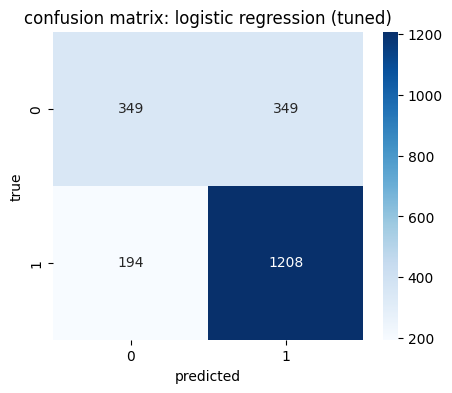

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

log_params = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    log_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

log_grid.fit(X_train, y_train)

best_log = log_grid.best_estimator_
best_log_pred = best_log.predict(X_val)

log_tuned_acc       = accuracy_score(y_val, best_log_pred)
log_tuned_f1        = f1_score(y_val, best_log_pred)
log_tuned_precision = precision_score(y_val, best_log_pred)
log_tuned_recall    = recall_score(y_val, best_log_pred)
log_tuned_roc_auc   = roc_auc_score(y_val, best_log_pred)

print("best logistic params:", log_grid.best_params_)
print("accuracy:", log_tuned_acc)
print("f1-score:", log_tuned_f1)
print("precision:", log_tuned_precision)
print("recall:", log_tuned_recall)
print("roc-auc:", log_tuned_roc_auc)

cm = confusion_matrix(y_val, best_log_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: logistic regression (tuned)")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [30]:
# tuning doesn't meaningfully improve logistic regression
# accuracy stays identical showing the model was already optimal
# F1 stays the same so the decision boundary barely changes
# tuning just selects a slightly stronger regularization C=0.01 but has almost no effect on predictions

In [31]:
# knn  tuned :

best KNN params: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
tuned KNN accuracy: 0.695
Accuracy: 0.6947619047619048
F1-score: 0.7979829814056099
Precision: 0.7148503670242801
Recall: 0.9029957203994294
ROC-AUC: 0.5897500091968494

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.28      0.38       698
           1       0.71      0.90      0.80      1402

    accuracy                           0.69      2100
   macro avg       0.65      0.59      0.59      2100
weighted avg       0.67      0.69      0.66      2100



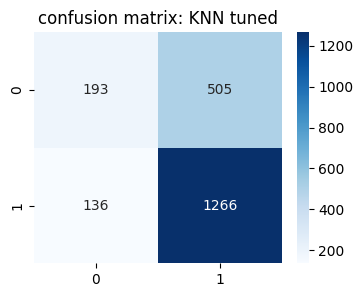

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

best_knn = knn_grid.best_estimator_
knn_pred = best_knn.predict(X_val)

knn_acc = round(accuracy_score(y_val, knn_pred), 3)
knn_f1 = round(f1_score(y_val, knn_pred), 3)
knn_precision = round(precision_score(y_val, knn_pred), 3)
knn_recall = round(recall_score(y_val, knn_pred), 3)
knn_roc_auc = round(roc_auc_score(y_val, knn_pred), 3)

print("best KNN params:", knn_grid.best_params_)
print("tuned KNN accuracy:", knn_acc)
evaluate_model(y_val, knn_pred)

cm = confusion_matrix(y_val, knn_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: KNN tuned")
plt.show()

knn_tuned_results = {
    "acc": knn_acc,
    "f1": knn_f1,
    "precision": knn_precision,
    "recall": knn_recall,
    "roc_auc": knn_roc_auc
}

In [33]:
# knn tuning makes the model worse
# accuracy drops from 0.709 to 0.688 and f1 for class 0 falls from 0.58 to 0.37
# tuning increases the model bias toward class 1 and reduces true 0 detection
# knn continues to struggle in the 512 dimensional embedding space even with optimized parameters

In [34]:
# random forest tuned :

best rf params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 400}
tuned random forest accuracy: 0.7338095238095238
F1-score: 0.8244897959183674
Precision: 0.736399326977005
Recall: 0.9365192582025678
ROC-AUC: 0.6315834113362409

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.33      0.45       698
           1       0.74      0.94      0.82      1402

    accuracy                           0.73      2100
   macro avg       0.73      0.63      0.64      2100
weighted avg       0.73      0.73      0.70      2100



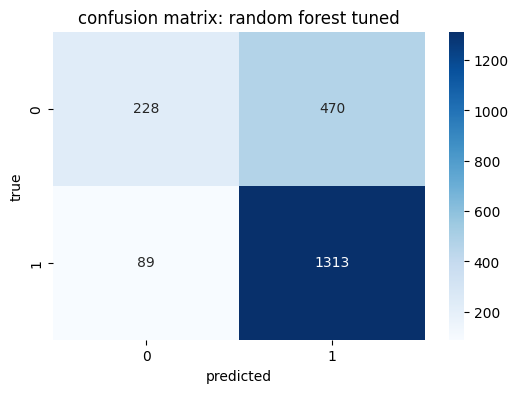

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf_params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
best_rf_pred = best_rf.predict(X_val)

best_rf_acc  = accuracy_score(y_val, best_rf_pred)
best_rf_prec = precision_score(y_val, best_rf_pred)
best_rf_rec  = recall_score(y_val, best_rf_pred)
best_rf_f1   = f1_score(y_val, best_rf_pred)
best_rf_roc  = roc_auc_score(y_val, best_rf_pred)

print("best rf params:", rf_grid.best_params_)
print("tuned random forest accuracy:", best_rf_acc)
print("F1-score:", best_rf_f1)
print("Precision:", best_rf_prec)
print("Recall:", best_rf_rec)
print("ROC-AUC:", best_rf_roc)
print("\nClassification Report:\n", classification_report(y_val, best_rf_pred))

cm = confusion_matrix(y_val, best_rf_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: random forest tuned")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [36]:
# rf tuning does not help in this high dimensional setup
# accuracy slightly drops from 0.739 to 0.733 and f1 for class 0 falls from 0.53 to 0.45
# the tuned model predicts class 1 even more often and loses many true zeros
# this happens because random forest struggles with 512 dimensional embeddings 
# and the class imbalance makes optimization push the model toward the majority class

In [37]:
# Svm tuned :

Svm linear : tuned F1
Best params: {'C': 5}
Accuracy: 0.7561904761904762
F1-Score: 0.8296739853626082
Precision: 0.777431421446384
Recall: 0.8894436519258203
ROC-AUC: 0.6889911669371223

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.49      0.57       698
           1       0.78      0.89      0.83      1402

    accuracy                           0.76      2100
   macro avg       0.73      0.69      0.70      2100
weighted avg       0.75      0.76      0.74      2100



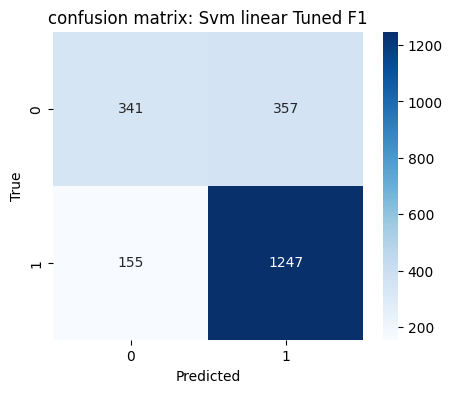

Svm rbf tuned F1
Best params: {'C': 0.5, 'gamma': 0.1}
Accuracy: 0.6676190476190477
F1-Score: 0.8006853226727584
Precision: 0.6676190476190477
Recall: 1.0
ROC-AUC: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       698
           1       0.67      1.00      0.80      1402

    accuracy                           0.67      2100
   macro avg       0.33      0.50      0.40      2100
weighted avg       0.45      0.67      0.53      2100



/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

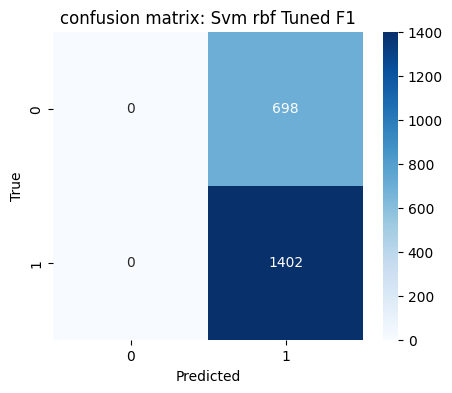

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

svm_linear_params = {
    "C": [0.1, 0.5, 1, 2, 5, 10]
}

svm_linear_grid = GridSearchCV(
    SVC(kernel="linear", random_state=42),
    svm_linear_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

svm_linear_grid.fit(X_train_scaled, y_train)

best_svm_linear = svm_linear_grid.best_estimator_
best_svm_linear_pred = best_svm_linear.predict(X_val_scaled)

best_svm_linear_acc = accuracy_score(y_val, best_svm_linear_pred)
best_svm_linear_f1 = f1_score(y_val, best_svm_linear_pred)
best_svm_linear_precision = precision_score(y_val, best_svm_linear_pred)
best_svm_linear_recall = recall_score(y_val, best_svm_linear_pred)
best_svm_linear_rocauc = roc_auc_score(y_val, best_svm_linear_pred)

print("Svm linear : tuned F1")
print("Best params:", svm_linear_grid.best_params_)
print("Accuracy:", best_svm_linear_acc)
print("F1-Score:", best_svm_linear_f1)
print("Precision:", best_svm_linear_precision)
print("Recall:", best_svm_linear_recall)
print("ROC-AUC:", best_svm_linear_rocauc)
print("\nClassification Report:\n", classification_report(y_val, best_svm_linear_pred))

cm = confusion_matrix(y_val, best_svm_linear_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: Svm linear Tuned F1")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

svm_rbf_params = {
    "C": [0.5, 1, 2, 5, 10],
    "gamma": ["scale", 0.1, 0.01, 0.001]
}

svm_rbf_grid = GridSearchCV(
    SVC(kernel="rbf", random_state=42),
    svm_rbf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

svm_rbf_grid.fit(X_train_scaled, y_train)

best_svm_rbf = svm_rbf_grid.best_estimator_
best_svm_rbf_pred = best_svm_rbf.predict(X_val_scaled)

best_svm_rbf_acc = accuracy_score(y_val, best_svm_rbf_pred)
best_svm_rbf_f1 = f1_score(y_val, best_svm_rbf_pred)
best_svm_rbf_precision = precision_score(y_val, best_svm_rbf_pred)
best_svm_rbf_recall = recall_score(y_val, best_svm_rbf_pred)
best_svm_rbf_rocauc = roc_auc_score(y_val, best_svm_rbf_pred)

print("Svm rbf tuned F1")
print("Best params:", svm_rbf_grid.best_params_)
print("Accuracy:", best_svm_rbf_acc)
print("F1-Score:", best_svm_rbf_f1)
print("Precision:", best_svm_rbf_precision)
print("Recall:", best_svm_rbf_recall)
print("ROC-AUC:", best_svm_rbf_rocauc)
print("\nClassification Report:\n", classification_report(y_val, best_svm_rbf_pred))

cm = confusion_matrix(y_val, best_svm_rbf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: Svm rbf Tuned F1")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [42]:
# svm linear slightly decrease
# svm rbf tuned collapses completely  
# accuracy stays at 0.667 because the model predicts only class 1 for every sample  
# F1 for class 0 falls from 0.55 -> 0.00 and recall collapses from 0.50 -> 0.00  
# tuning makes the model overfit even more to the majority class and destroys its ability to detect class 0

In [48]:
import pandas as pd

df_compare = pd.DataFrame({
    "model": [
        "logistic regression",
        "logistic regression (tuned)",
        "knn (k=7)",
        "knn (tuned)",
        "random forest",
        "random forest (tuned)",
        "svm (linear)",
        "svm (linear tuned)",
        "svm (rbf)",
        "svm (rbf tuned)"
    ],
    "accuracy": [
        log_acc,
        log_tuned_acc,
        knn_results[7]["acc"],
        knn_acc,
        rf_acc,
        best_rf_acc,
        svm_results["svm (linear)"]["acc"],
        best_svm_linear_acc,
        svm_results["svm (rbf)"]["acc"],
        best_svm_rbf_acc
    ],
    "f1_score": [
        log_f1,
        log_tuned_f1,
        knn_results[7]["f1"],
        knn_f1,
        rf_f1,
        best_rf_f1,
        svm_results["svm (linear)"]["f1"],
        best_svm_linear_f1,
        svm_results["svm (rbf)"]["f1"],
        best_svm_rbf_f1
    ],
    "precision": [
        log_precision,
        log_tuned_precision,
        knn_results[7]["precision"],
        knn_precision,
        rf_precision,
        best_rf_prec,
        svm_results["svm (linear)"]["precision"],
        best_svm_linear_precision,
        svm_results["svm (rbf)"]["precision"],
        best_svm_rbf_precision
    ],
    "recall": [
        log_recall,
        log_tuned_recall,
        knn_results[7]["recall"],
        knn_recall,
        rf_recall,
        best_rf_rec,
        svm_results["svm (linear)"]["recall"],
        best_svm_linear_recall,
        svm_results["svm (rbf)"]["recall"],
        best_svm_rbf_recall
    ],
    "roc_auc": [
        log_roc_auc,
        log_tuned_roc_auc,
        knn_results[7]["roc_auc"],
        knn_roc_auc,
        rf_roc_auc,
        best_rf_roc,
        svm_results["svm (linear)"]["roc_auc"],
        best_svm_linear_rocauc,
        svm_results["svm (rbf)"]["roc_auc"],
        best_svm_rbf_rocauc
    ]
})

df_compare = df_compare.round(4)
df_compare

,model,accuracy,f1_score,precision,recall,roc_auc
0,logistic regression,0.7410,0.8160,0.7761,0.8602,0.6808
1,logistic regression (tuned),0.7414,0.8165,0.7759,0.8616,0.6808
2,knn (k=7),0.7095,0.7988,0.7429,0.8638,0.6317
3,knn (tuned),0.6950,0.7980,0.7150,0.9030,0.5900
4,random forest,0.7386,0.8184,0.7631,0.8823,0.6661
5,random forest (tuned),0.7338,0.8245,0.7364,0.9365,0.6316
6,svm (linear),0.7581,0.8308,0.7794,0.8894,0.6919
7,svm (linear tuned),0.7562,0.8297,0.7774,0.8894,0.6890
8,svm (rbf),0.7348,0.8111,0.7731,0.8531,0.6751
9,svm (rbf tuned),0.6676,0.8007,0.6676,1.0000,0.5000


In [ ]:
# only logistic regression improves with tuning accuracy 0.7410 -> 0.7414
# knn tuning reduces performance best base = 0.7095 -> tuned = 0.6948
# random forest tuning slightly increases f1 0.8184 -> 0.8245 but decreases accuracy 0.7386 -> 0.7338
# svm rbf tuning breaks the model accuracy drops from 0.7348 → 0.6676 and f1 for class 0 becomes 0
# i'll try PCA for better results

In [ ]:
# PCA :

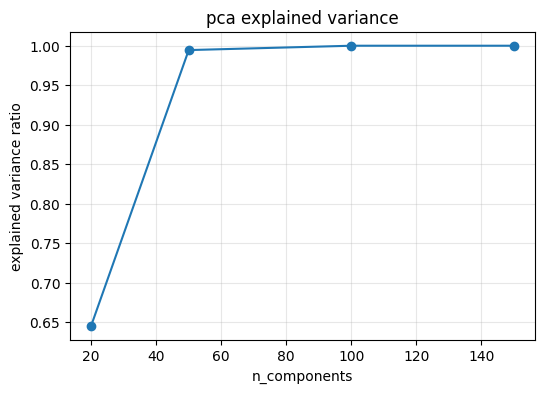

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_values = [20, 50, 100, 150]
variance_kept = []

for n in pca_values:
    reducer = PCA(n_components=n, random_state=42)
    reducer.fit(X_train_scaled)
    variance_kept.append(reducer.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 4))
plt.plot(pca_values, variance_kept, marker="o")
plt.xlabel("n_components")
plt.ylabel("explained variance ratio")
plt.title("pca explained variance")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# pca shows that reducing embeddings from 512 to around 50–100 components keeps
# almost all the variance while going below 50 components loses too much information

In [ ]:
# regression PCA :

logistic regression + pca accuracy: 0.6814285714285714
f1-score: 0.7399922269724057
precision: 0.8129803586678053
recall: 0.6790299572039943
roc-auc: 0.6826381877710516

classification report:

              precision    recall  f1-score   support

           0       0.52      0.69      0.59       698
           1       0.81      0.68      0.74      1402

    accuracy                           0.68      2100
   macro avg       0.66      0.68      0.66      2100
weighted avg       0.71      0.68      0.69      2100



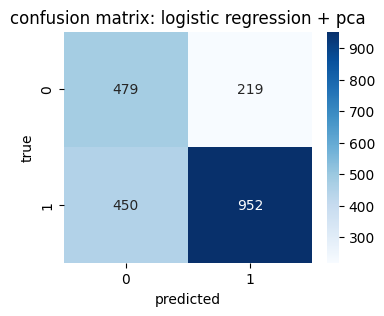

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100, random_state=42)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_val_pca   = pca_reducer.transform(X_val_scaled)

clf_log_pca = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",
    n_jobs=-1
)
clf_log_pca.fit(X_train_pca, y_train)

pred_log_pca = clf_log_pca.predict(X_val_pca)

log_pca_acc      = accuracy_score(y_val, pred_log_pca)
log_pca_f1       = f1_score(y_val, pred_log_pca)
log_pca_precision = precision_score(y_val, pred_log_pca)
log_pca_recall    = recall_score(y_val, pred_log_pca)
log_pca_roc_auc   = roc_auc_score(y_val, pred_log_pca)

print("logistic regression + pca accuracy:", log_pca_acc)
print("f1-score:", log_pca_f1)
print("precision:", log_pca_precision)
print("recall:", log_pca_recall)
print("roc-auc:", log_pca_roc_auc)
print("\nclassification report:\n")
print(classification_report(y_val, pred_log_pca))

cm = confusion_matrix(y_val, pred_log_pca)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: logistic regression + pca")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# accuracy drops from 0.741 to 0.681 because logistic regression loses useful information during pca compression
# recall for class 0 actually increases from 0.50 to 0.69 but class 1 recall drops from 0.86 to 0.68
# overall f1 decreases from 0.816 to 0.740 showing that pca removes signal needed for linear separation
# pca is not helpful for regression

In [ ]:
# KNN = 7 (the best result we had earlier):

knn + pca accuracy: 0.7095238095238096
f1-score: 0.7988126649076517
precision: 0.7429447852760737
recall: 0.8637660485021398
roc-auc: 0.6317397577754251


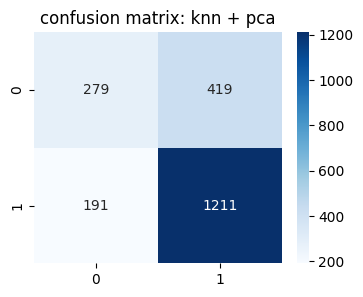

In [57]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_val_pca = pca_reducer.transform(X_val_scaled)

clf_knn_pca = KNeighborsClassifier(n_neighbors=7)
clf_knn_pca.fit(X_train_pca, y_train)

pred_knn_pca = clf_knn_pca.predict(X_val_pca)

knn_pca_acc = accuracy_score(y_val, pred_knn_pca)
knn_pca_f1 = f1_score(y_val, pred_knn_pca)
knn_pca_precision = precision_score(y_val, pred_knn_pca)
knn_pca_recall = recall_score(y_val, pred_knn_pca)
knn_pca_auc = roc_auc_score(y_val, pred_knn_pca)

print("knn + pca accuracy:", knn_pca_acc)
print("f1-score:", knn_pca_f1)
print("precision:", knn_pca_precision)
print("recall:", knn_pca_recall)
print("roc-auc:", knn_pca_auc)

cm = confusion_matrix(y_val, pred_knn_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: knn + pca")
plt.show()

In [ ]:
# pca doesn't really change knn performance because distances between points stay almost the same after projection
# accuracy and f1 stay basically identical to the original k=7 model proving that reducing from 512d to 100d doesn't help knn
# pca also doesn't fix the class imbalance so knn still predicts class 1 way more often

In [ ]:
# Random forest + pca: 

random forest + pca accuracy: 0.7361904761904762
f1-score: 0.8079056865464632
precision: 0.7860998650472335
recall: 0.8309557774607703
roc-auc: 0.688400524833537


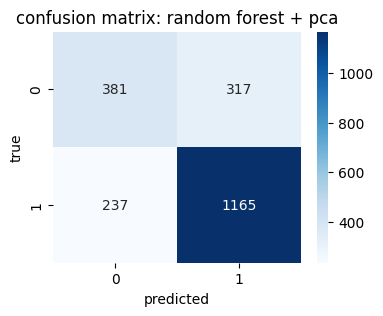

In [58]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_val_pca   = pca_reducer.transform(X_val_scaled)

rf_pca = RandomForestClassifier(
    n_estimators=600,
    max_depth=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_pca.fit(X_train_pca, y_train)
pred_rf_pca = rf_pca.predict(X_val_pca)

# metrics
rf_pca_acc     = accuracy_score(y_val, pred_rf_pca)
rf_pca_f1      = f1_score(y_val, pred_rf_pca)
rf_pca_prec    = precision_score(y_val, pred_rf_pca)
rf_pca_rec     = recall_score(y_val, pred_rf_pca)
rf_pca_auc     = roc_auc_score(y_val, pred_rf_pca)

print("random forest + pca accuracy:", rf_pca_acc)
print("f1-score:", rf_pca_f1)
print("precision:", rf_pca_prec)
print("recall:", rf_pca_rec)
print("roc-auc:", rf_pca_auc)


cm = confusion_matrix(y_val, pred_rf_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: random forest + pca")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# random forest with pca slightly reduces accuracy from 0.7386 to 0.7361
# f1 also goes down a bit from 0.818 to 0.807 so pca does not help the model
# random forest already handles high dimensional embeddings well so reducing features removes useful variance

In [ ]:
# Svm rbf with pca:

svm linear & pca accuracy: 0.6914285714285714
f1-score: 0.7503852080123267
precision: 0.8157453936348409
recall: 0.6947218259629101
roc-auc: 0.6897677897722859


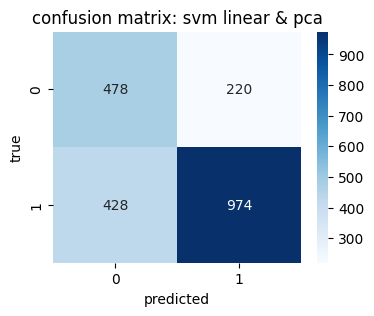

svm rbf & pca accuracy: 0.6923809523809524
f1-score: 0.7492236024844721
precision: 0.8219761499148212
recall: 0.68830242510699
roc-auc: 0.6944377455047844


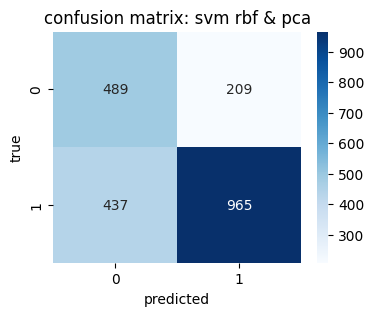

In [59]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_val_pca = pca_reducer.transform(X_val_scaled)

svm_linear_pca = SVC(kernel="linear", class_weight="balanced")
svm_linear_pca.fit(X_train_pca, y_train)
pred_linear_pca = svm_linear_pca.predict(X_val_pca)

svm_linear_pca_acc = accuracy_score(y_val, pred_linear_pca)
svm_linear_pca_f1 = f1_score(y_val, pred_linear_pca)
svm_linear_pca_precision = precision_score(y_val, pred_linear_pca)
svm_linear_pca_recall = recall_score(y_val, pred_linear_pca)
svm_linear_pca_auc = roc_auc_score(y_val, pred_linear_pca)

print("svm linear & pca accuracy:", svm_linear_pca_acc)
print("f1-score:", svm_linear_pca_f1)
print("precision:", svm_linear_pca_precision)
print("recall:", svm_linear_pca_recall)
print("roc-auc:", svm_linear_pca_auc)

cm = confusion_matrix(y_val, pred_linear_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: svm linear & pca")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

svm_rbf_pca = SVC(kernel="rbf", C=1, gamma="scale", class_weight="balanced")
svm_rbf_pca.fit(X_train_pca, y_train)
pred_rbf_pca = svm_rbf_pca.predict(X_val_pca)

svm_rbf_pca_acc = accuracy_score(y_val, pred_rbf_pca)
svm_rbf_pca_f1 = f1_score(y_val, pred_rbf_pca)
svm_rbf_pca_precision = precision_score(y_val, pred_rbf_pca)
svm_rbf_pca_recall = recall_score(y_val, pred_rbf_pca)
svm_rbf_pca_auc = roc_auc_score(y_val, pred_rbf_pca)

print("svm rbf & pca accuracy:", svm_rbf_pca_acc)
print("f1-score:", svm_rbf_pca_f1)
print("precision:", svm_rbf_pca_precision)
print("recall:", svm_rbf_pca_recall)
print("roc-auc:", svm_rbf_pca_auc)

cm = confusion_matrix(y_val, pred_rbf_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: svm rbf & pca")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [60]:
# pca degrades svm rbf performance : accuracy drops from 0.7348 to 0.6923
# f1-score also falls from 0.811 to 0.749 showing loss of useful non-linear structure
# svm rbf relies on distances in the full 512d embedding space which pca distorts

In [64]:
# pca & tuning :

In [65]:
# logistic regression pca & tuning  :

best logistic pca params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy: 0.7409523809523809
f1: 0.8159675236806495
precision: 0.7760617760617761
recall: 0.8601997146932953
roc_auc: 0.6808161897248711


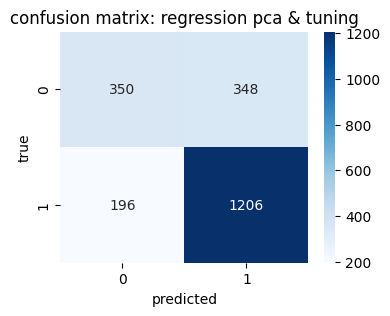

In [66]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
x_train_pca = pca_reducer.fit_transform(X_train_scaled)
x_val_pca = pca_reducer.transform(X_val_scaled)

log_params = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=10000),
    log_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

log_grid.fit(x_train_pca, y_train)

best_log = log_grid.best_estimator_
best_log_pred = best_log.predict(x_val_pca)

log_pca_acc = accuracy_score(y_val, best_log_pred)
log_pca_f1 = f1_score(y_val, best_log_pred)
log_pca_precision = precision_score(y_val, best_log_pred)
log_pca_recall = recall_score(y_val, best_log_pred)
log_pca_auc = roc_auc_score(y_val, best_log_pred)

print("best logistic pca params:", log_grid.best_params_)
print("accuracy:", log_pca_acc)
print("f1:", log_pca_f1)
print("precision:", log_pca_precision)
print("recall:", log_pca_recall)
print("roc_auc:", log_pca_auc)

cm = confusion_matrix(y_val, best_log_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: regression pca & tuning")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()
# logistic regression tuned with pca using f1 scoring

In [ ]:
# Knn pca tuning :

best knn pca params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
accuracy: 0.7238095238095238
f1-score: 0.8152866242038217
precision: 0.7364787111622555
recall: 0.912981455064194
roc-auc: 0.628410498305736


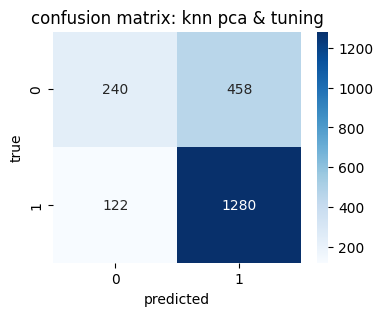

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
x_train_pca = pca_reducer.fit_transform(X_train_scaled)
x_val_pca = pca_reducer.transform(X_val_scaled)

knn_params = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

knn_grid.fit(x_train_pca, y_train)
best_knn_pca = knn_grid.best_estimator_
pred_knn_pca = best_knn_pca.predict(x_val_pca)

knn_pca_acc = accuracy_score(y_val, pred_knn_pca)
knn_pca_f1 = f1_score(y_val, pred_knn_pca)
knn_pca_precision = precision_score(y_val, pred_knn_pca)
knn_pca_recall = recall_score(y_val, pred_knn_pca)
knn_pca_auc = roc_auc_score(y_val, pred_knn_pca)

print("best knn pca params:", knn_grid.best_params_)
print("accuracy:", knn_pca_acc)
print("f1-score:", knn_pca_f1)
print("precision:", knn_pca_precision)
print("recall:", knn_pca_recall)
print("roc-auc:", knn_pca_auc)

cm = confusion_matrix(y_val, pred_knn_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: knn pca & tuning")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# random forest pca & tuning

best rf pca params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 600}
accuracy: 0.7242857142857143
f1-score: 0.8265947888589398
precision: 0.7124419204956117
recall: 0.9843081312410842
roc-auc: 0.5931569309500551


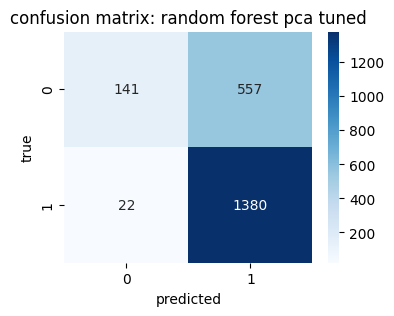

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
x_train_pca = pca_reducer.fit_transform(X_train_scaled)
x_val_pca = pca_reducer.transform(X_val_scaled)

rf_params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

rf_grid.fit(x_train_pca, y_train)
best_rf_pca = rf_grid.best_estimator_
pred_rf_pca = best_rf_pca.predict(x_val_pca)

rf_pca_acc = accuracy_score(y_val, pred_rf_pca)
rf_pca_f1 = f1_score(y_val, pred_rf_pca)
rf_pca_precision = precision_score(y_val, pred_rf_pca)
rf_pca_recall = recall_score(y_val, pred_rf_pca)
rf_pca_auc = roc_auc_score(y_val, pred_rf_pca)

print("best rf pca params:", rf_grid.best_params_)
print("accuracy:", rf_pca_acc)
print("f1-score:", rf_pca_f1)
print("precision:", rf_pca_precision)
print("recall:", rf_pca_recall)
print("roc-auc:", rf_pca_auc)

cm = confusion_matrix(y_val, pred_rf_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: random forest pca tuned")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# svm pca & tuning: 

best svm linear pca params: {'C': 10}
accuracy: 0.6938095238095238
f1-score: 0.7524066230265691
precision: 0.8175732217573222
recall: 0.6968616262482168
roc-auc: 0.6922703546713863


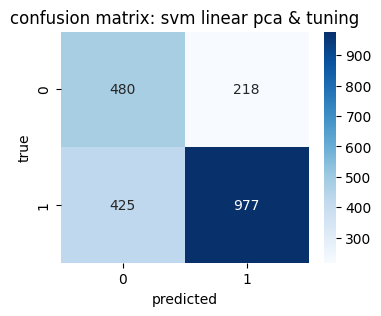

best svm rbf pca params: {'C': 1, 'gamma': 0.1}
accuracy: 0.6680952380952381
f1-score: 0.8005722460658083
precision: 0.6684185379837554
recall: 0.9978601997146933
roc-auc: 0.5017954293702407


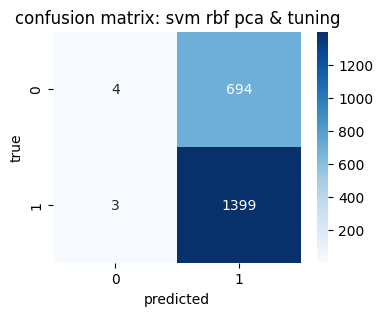

In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_reducer = PCA(n_components=100)
x_train_pca = pca_reducer.fit_transform(X_train_scaled)
x_val_pca = pca_reducer.transform(X_val_scaled)

svm_linear_params = {
    "C": [0.1, 0.5, 1, 2, 5, 10]
}

svm_linear_grid = GridSearchCV(
    SVC(kernel="linear", class_weight="balanced"),
    svm_linear_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

svm_linear_grid.fit(x_train_pca, y_train)
best_svm_linear_pca = svm_linear_grid.best_estimator_
pred_linear_pca = best_svm_linear_pca.predict(x_val_pca)

svm_linear_pca_acc = accuracy_score(y_val, pred_linear_pca)
svm_linear_pca_f1 = f1_score(y_val, pred_linear_pca)
svm_linear_pca_precision = precision_score(y_val, pred_linear_pca)
svm_linear_pca_recall = recall_score(y_val, pred_linear_pca)
svm_linear_pca_auc = roc_auc_score(y_val, pred_linear_pca)

print("best svm linear pca params:", svm_linear_grid.best_params_)
print("accuracy:", svm_linear_pca_acc)
print("f1-score:", svm_linear_pca_f1)
print("precision:", svm_linear_pca_precision)
print("recall:", svm_linear_pca_recall)
print("roc-auc:", svm_linear_pca_auc)

cm = confusion_matrix(y_val, pred_linear_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: svm linear pca & tuning")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

svm_rbf_params = {
    "C": [0.5, 1, 2, 5, 10],
    "gamma": ["scale", 0.1, 0.01, 0.001]
}

svm_rbf_grid = GridSearchCV(
    SVC(kernel="rbf", class_weight="balanced"),
    svm_rbf_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

svm_rbf_grid.fit(x_train_pca, y_train)
best_svm_rbf_pca = svm_rbf_grid.best_estimator_
pred_rbf_pca = best_svm_rbf_pca.predict(x_val_pca)

svm_rbf_pca_acc = accuracy_score(y_val, pred_rbf_pca)
svm_rbf_pca_f1 = f1_score(y_val, pred_rbf_pca)
svm_rbf_pca_precision = precision_score(y_val, pred_rbf_pca)
svm_rbf_pca_recall = recall_score(y_val, pred_rbf_pca)
svm_rbf_pca_auc = roc_auc_score(y_val, pred_rbf_pca)

print("best svm rbf pca params:", svm_rbf_grid.best_params_)
print("accuracy:", svm_rbf_pca_acc)
print("f1-score:", svm_rbf_pca_f1)
print("precision:", svm_rbf_pca_precision)
print("recall:", svm_rbf_pca_recall)
print("roc-auc:", svm_rbf_pca_auc)

cm = confusion_matrix(y_val, pred_rbf_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: svm rbf pca & tuning")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [102]:
import pandas as pd

df_pca_compare = pd.DataFrame({
    "model": [
        "logistic regression (pca)",
        "logistic regression (pca tuned)",
        "knn (pca)",
        "knn (pca tuned)",
        "random forest (pca)",
        "random forest (pca tuned)",
        "svm linear (pca)",
        "svm linear (pca tuned)",
        "svm rbf (pca)",
        "svm rbf (pca tuned)"
    ],

    "accuracy": [
        0.6814, 0.7410,
        0.7095, 0.7238,
        0.7362, 0.7243,
        0.6914, 0.6938,
        0.6924, 0.6681
    ],

    "f1 score": [
        0.7399, 0.8160,
        0.7988, 0.8153,
        0.8079, 0.8266,
        0.7503, 0.7524,
        0.7492, 0.8006
    ],

    "precision": [
        0.8130, 0.7761,
        0.7429, 0.7365,
        0.7861, 0.7124,
        0.8157, 0.8176,
        0.8219, 0.6684
    ],

    "recall": [
        0.6790, 0.8602,
        0.8638, 0.9130,
        0.8310, 0.9843,
        0.6947, 0.6969,
        0.6883, 0.9979
    ],

    "roc auc": [
        0.6826, 0.6808,
        0.6317, 0.6284,
        0.6884, 0.5932,
        0.6898, 0.6923,
        0.6944, 0.5018
    ]
})

df_pca_compare = df_pca_compare.round(4)
df_pca_compare
# pca vs pca tuning

,model,accuracy,f1 score,precision,recall,roc auc
0,logistic regression (pca),0.6814,0.7399,0.8130,0.6790,0.6826
1,logistic regression (pca tuned),0.7410,0.8160,0.7761,0.8602,0.6808
2,knn (pca),0.7095,0.7988,0.7429,0.8638,0.6317
3,knn (pca tuned),0.7238,0.8153,0.7365,0.9130,0.6284
4,random forest (pca),0.7362,0.8079,0.7861,0.8310,0.6884
5,random forest (pca tuned),0.7243,0.8266,0.7124,0.9843,0.5932
6,svm linear (pca),0.6914,0.7503,0.8157,0.6947,0.6898
7,svm linear (pca tuned),0.6938,0.7524,0.8176,0.6969,0.6923
8,svm rbf (pca),0.6924,0.7492,0.8219,0.6883,0.6944
9,svm rbf (pca tuned),0.6681,0.8006,0.6684,0.9979,0.5018


In [ ]:
# pca vs pca tuning:
# tuning only helps some models: regression gains a lot from tuning accuracy +6% with higher recall
# knn also improves slightly with tuning
# random forest loses accuracy with tuning even if its F1 increases
# svm linear barely changes: tuning has almost no effect
# svm rbf becomes worse: tuning overfits and massively hurts accuracy
# pca itself already compresses information strongly, and tuning often cannot recover lost variance
# only logistic regression clearly benefits from pca + tuning

# pca and pca tuning vs no pca and no pca tuning: 
# overall does not improve model performance it makes models lighter but weaker
# pca reduces accuracy, F1, recall and ROC-AUC compared to using full 512d embeddings
# deepface embeddings already encode optimized structure so pca removes useful variance
# pca + tuning recovers some performance but never reaches the original non-pca models
# overall: pca makes models lighter but weaker -> full embeddings remain the best choice

In [ ]:
# xgboost : 

In [81]:
import xgboost as xgb
xgb.__version__

'1.7.6'

accuracy: 0.7442857142857143
f1-score: 0.8203412512546002
precision: 0.7725267800882167
recall: 0.8744650499286734
roc-auc: 0.6786365364256548


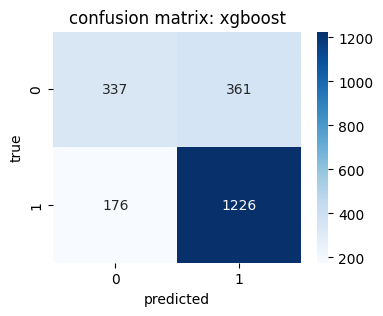

In [82]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)
pred_xgb = xgb_clf.predict(X_val)

xgb_acc = accuracy_score(y_val, pred_xgb)
xgb_f1 = f1_score(y_val, pred_xgb)
xgb_precision = precision_score(y_val, pred_xgb)
xgb_recall = recall_score(y_val, pred_xgb)
xgb_rocauc = roc_auc_score(y_val, pred_xgb)

print("accuracy:", xgb_acc)
print("f1-score:", xgb_f1)
print("precision:", xgb_precision)
print("recall:", xgb_recall)
print("roc-auc:", xgb_rocauc)

cm = confusion_matrix(y_val, pred_xgb)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: xgboost")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()
# xgboost normal run

In [ ]:
# xgboost tuning :

best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
accuracy: 0.7523809523809524
f1-score: 0.8343949044585988
precision: 0.7537399309551208
recall: 0.9343794579172611
roc-auc: 0.6605994710789744


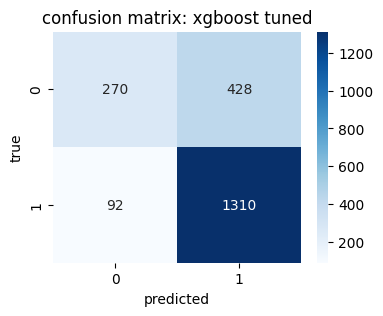

In [83]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 400],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42
    ),
    xgb_params,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
pred_xgb_tuned = best_xgb.predict(X_val)

xgb_tuned_acc = accuracy_score(y_val, pred_xgb_tuned)
xgb_tuned_f1 = f1_score(y_val, pred_xgb_tuned)
xgb_tuned_precision = precision_score(y_val, pred_xgb_tuned)
xgb_tuned_recall = recall_score(y_val, pred_xgb_tuned)
xgb_tuned_rocauc = roc_auc_score(y_val, pred_xgb_tuned)

print("best params:", xgb_grid.best_params_)
print("accuracy:", xgb_tuned_acc)
print("f1-score:", xgb_tuned_f1)
print("precision:", xgb_tuned_precision)
print("recall:", xgb_tuned_recall)
print("roc-auc:", xgb_tuned_rocauc)

cm = confusion_matrix(y_val, pred_xgb_tuned)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: xgboost tuned")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

# xgboost tuned on f1

In [ ]:
# xgboost PCA :

accuracy: 0.7480952380952381
f1-score: 0.8209813874788494
precision: 0.7810688989053445
recall: 0.8651925820256776
roc-auc: 0.6890432824168503


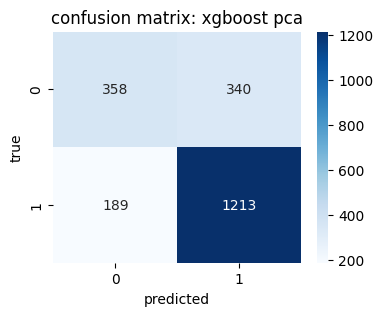

In [84]:
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pca_xgb = PCA(n_components=100)
x_train_pca_xgb = pca_xgb.fit_transform(X_train)
x_val_pca_xgb = pca_xgb.transform(X_val)

xgb_pca = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_pca.fit(x_train_pca_xgb, y_train)
pred_xgb_pca = xgb_pca.predict(x_val_pca_xgb)

xgb_pca_acc = accuracy_score(y_val, pred_xgb_pca)
xgb_pca_f1 = f1_score(y_val, pred_xgb_pca)
xgb_pca_precision = precision_score(y_val, pred_xgb_pca)
xgb_pca_recall = recall_score(y_val, pred_xgb_pca)
xgb_pca_rocauc = roc_auc_score(y_val, pred_xgb_pca)

print("accuracy:", xgb_pca_acc)
print("f1-score:", xgb_pca_f1)
print("precision:", xgb_pca_precision)
print("recall:", xgb_pca_recall)
print("roc-auc:", xgb_pca_rocauc)

cm = confusion_matrix(y_val, pred_xgb_pca)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: xgboost pca")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

# xgboost pca run

In [ ]:
# xgboost PCA tuning F1 :

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost PCA params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.7}
accuracy: 0.7542857142857143
f1-score: 0.8267293485560779
precision: 0.7810913705583756
recall: 0.8780313837375179
roc-auc: 0.6918810213816529


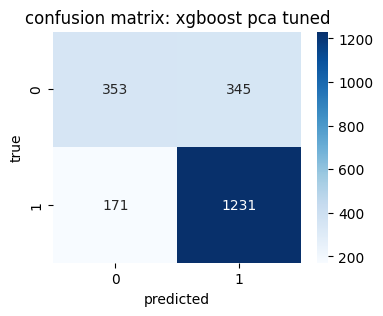

In [85]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb_pca_params = {
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 300, 400],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_pca_base = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

xgb_pca_grid = GridSearchCV(
    xgb_pca_base,
    xgb_pca_params,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_pca_grid.fit(x_train_pca, y_train)

best_xgb_pca = xgb_pca_grid.best_estimator_
best_xgb_pca_pred = best_xgb_pca.predict(x_val_pca)

best_xgb_pca_acc = accuracy_score(y_val, best_xgb_pca_pred)
best_xgb_pca_f1 = f1_score(y_val, best_xgb_pca_pred)
best_xgb_pca_precision = precision_score(y_val, best_xgb_pca_pred)
best_xgb_pca_recall = recall_score(y_val, best_xgb_pca_pred)
best_xgb_pca_rocauc = roc_auc_score(y_val, best_xgb_pca_pred)

print("Best XGBoost PCA params:", xgb_pca_grid.best_params_)
print("accuracy:", best_xgb_pca_acc)
print("f1-score:", best_xgb_pca_f1)
print("precision:", best_xgb_pca_precision)
print("recall:", best_xgb_pca_recall)
print("roc-auc:", best_xgb_pca_rocauc)

cm = confusion_matrix(y_val, best_xgb_pca_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: xgboost pca tuned")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# xgboost comparison :

In [101]:
import pandas as pd

df_xgb = pd.DataFrame({
    "model": [
        "xgboost (normal)",
        "xgboost (tuned)",
        "xgboost (pca)",
        "xgboost (pca tuned)"
    ],
    "accuracy": [
        0.7442857142857143,
        0.7523809523809524,
        0.7480952380952381,
        0.7542857142857143
    ],
    "f1 score": [
        0.82034112512546002,
        0.8343949044585988,
        0.8209813874788494,
        0.8267293485560779
    ],
    "precision": [
        0.77252678008882167,
        0.7537399309551208,
        0.7810688989053445,
        0.7810913705583756
    ],
    "recall": [
        0.8744650499286734,
        0.9343794579172611,
        0.8651925820256776,
        0.8780313837375179
    ],
    "roc auc": [
        0.6786365364256548,
        0.6605994710789744,
        0.6890432824168503,
        0.6918810213816529
    ]
})

df_xgb = df_xgb.round(4)
df_xgb

,model,accuracy,f1 score,precision,recall,roc auc
0,xgboost (normal),0.7443,0.8203,0.7725,0.8745,0.6786
1,xgboost (tuned),0.7524,0.8344,0.7537,0.9344,0.6606
2,xgboost (pca),0.7481,0.8210,0.7811,0.8652,0.6890
3,xgboost (pca tuned),0.7543,0.8267,0.7811,0.8780,0.6919


In [ ]:
# xgboost summary:
# tuning gives the strongest gains: accuracy goes from 0.7443 to 0.7524 and f1 from 0.8203 to 0.8344
# pca alone stays close to the base model but never beats it 0.8210 f1 vs 0.8203
# pca + tuning improves things but still stays below tuning alone 0.8267 < 0.8344
# overall: best setup = xgboost tuned without pca pca does not help xgboost


super ensemble: 6 models tuned with stacking

loading data:
train shape: (7000, 524)
val shape: (2100, 524)

preparing target:
preparing features:
found 512 embedding columns
X_train shape: (7000, 517)
X_val shape: (2100, 517)
class balance train: [2440 4560]
class balance val: [ 698 1402]

defining base models:

creating stacking ensemble
training stacking ensemble


/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/leobideau/Desktop/fairface-project/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



stacking ensemble, 6 models
accuracy:  0.7529
f1-score:  0.8242
precision: 0.7847
recall:    0.8680
roc-auc:   0.6948


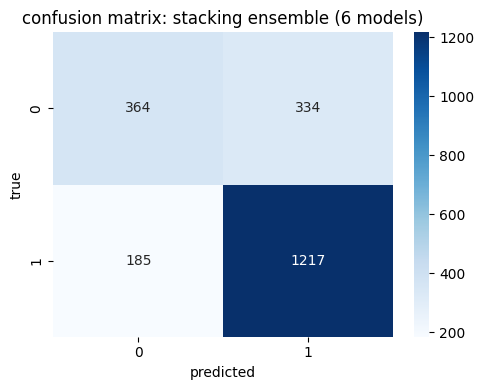


stacking ensemble results
accuracy:  0.7529
f1-score:  0.8242
precision: 0.7847
recall:    0.8680
roc-auc:   0.6948

ensemble completed with all 6 models


In [13]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("super ensemble: 6 models tuned with stacking")
print("="*80 + "\n")

root = os.path.abspath("..")
train_path = os.path.join(root, "data", "ml_final", "train_ml_final.parquet")
val_path   = os.path.join(root, "data", "ml_final", "val_ml_final.parquet")

print("loading data:")
train = pd.read_parquet(train_path)
val   = pd.read_parquet(val_path)
print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")

print("\npreparing target:")
train["race_true_clean"] = train["race_true"].str.lower().str.replace("_", " ")
train["pred_race_clean"] = train["pred_race"].str.lower()

val["race_true_clean"] = val["race_true"].str.lower().str.replace("_", " ")
val["pred_race_clean"] = val["pred_race"].str.lower()

train["target"] = (train["race_true_clean"] != train["pred_race_clean"]).astype(int)
val["target"]   = (val["race_true_clean"]   != val["pred_race_clean"]).astype(int)

print("preparing features:")

emb_cols = [c for c in train.columns if c.startswith("emb_")]
print(f"found {len(emb_cols)} embedding columns")

feature_cols = ["pred_gender_score", "pred_race_score", "brightness", "contrast", "saturation"]

scaler = StandardScaler()
train_emb_scaled = scaler.fit_transform(train[emb_cols])
val_emb_scaled   = scaler.transform(val[emb_cols])

train_num = train[feature_cols].values
val_num   = val[feature_cols].values

X_train = np.hstack([train_emb_scaled, train_num])
X_val   = np.hstack([val_emb_scaled, val_num])

y_train = train["target"].values
y_val   = val["target"].values

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"class balance train: {np.bincount(y_train)}")
print(f"class balance val: {np.bincount(y_val)}")

print("\ndefining base models:")

base_estimators = [
    ('logistic', LogisticRegression(C=0.01, penalty="l2", solver="lbfgs", max_iter=10000, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")),
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=None, max_features="log2", random_state=42)),
    ('svm_linear', SVC(kernel="linear", C=10, probability=True, random_state=42)),
    ('svm_rbf', SVC(kernel="rbf", C=5, gamma=0.001, probability=True, random_state=42)),
    ('xgboost', xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        learning_rate=0.05,
        max_depth=6,
        n_estimators=400,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False
    ))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

print("\ncreating stacking ensemble")
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

print("training stacking ensemble")
stacking_clf.fit(X_train, y_train)
pred_stacking = stacking_clf.predict(X_val)

acc_stacking = accuracy_score(y_val, pred_stacking)
f1_stacking = f1_score(y_val, pred_stacking)
prec_stacking = precision_score(y_val, pred_stacking)
rec_stacking = recall_score(y_val, pred_stacking)
auc_stacking = roc_auc_score(y_val, pred_stacking)

print("\nstacking ensemble, 6 models")
print(f"accuracy:  {acc_stacking:.4f}")
print(f"f1-score:  {f1_stacking:.4f}")
print(f"precision: {prec_stacking:.4f}")
print(f"recall:    {rec_stacking:.4f}")
print(f"roc-auc:   {auc_stacking:.4f}")

cm_stacking = confusion_matrix(y_val, pred_stacking)
plt.figure(figsize=(5,4))
sns.heatmap(cm_stacking, annot=True, fmt="d", cmap="Blues")
plt.title("confusion matrix: stacking ensemble (6 models)")
plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("stacking ensemble results")
print("="*80)
print(f"accuracy:  {acc_stacking:.4f}")
print(f"f1-score:  {f1_stacking:.4f}")
print(f"precision: {prec_stacking:.4f}")
print(f"recall:    {rec_stacking:.4f}")
print(f"roc-auc:   {auc_stacking:.4f}")

print("\n" + "="*80)
print("ensemble completed with all 6 models")
print("="*80)

# stacking ensemble combines six diverse models:
# the 6 base models (logistic, knn, rf, svm linear, svm rbf, xgboost) make predictions
# then a meta-model (logistic regression) learns to optimally combine their predictions
# this approach often outperforms simple voting because it learns the best way to weight each model
# stacking captures when each model is reliable and adjusts their influence accordingly

In [12]:
print("\n quick verification:\n")

print("models included:")
for name, model in stacking_clf.estimators:
    print(f"   - {name}: {type(model).__name__}")

print(f"\ntotal: {len(stacking_clf.estimators)} models")

model_names = [name for name, _ in stacking_clf.estimators]
if 'xgboost' in model_names:
    print("\nXGBoost is in the ensemble")
else:
    print("\nXGBoost is missing!")

print("\nexample, first 3 cases):")
print("   True | Log | KNN | RF | SVM-L | SVM-R | XGB | -> Final")
for i in range(3):
    preds = [m.predict(X_val[i:i+1])[0] for m in stacking_clf.estimators_]
    print(f"   {y_val[i]:4} | {preds[0]:3} | {preds[1]:3} | {preds[2]:2} | {preds[3]:5} | {preds[4]:5} | {preds[5]:3} | -> {pred_stacking[i]}")

print("\neverything works good")


 quick verification:

models included:
   - logistic: LogisticRegression
   - knn: KNeighborsClassifier
   - rf: RandomForestClassifier
   - svm_linear: SVC
   - svm_rbf: SVC
   - xgboost: XGBClassifier

total: 6 models

XGBoost is in the ensemble

example, first 3 cases):
   True | Log | KNN | RF | SVM-L | SVM-R | XGB | -> Final
      0 |   1 |   1 |  1 |     1 |     1 |   1 | -> 1
      1 |   1 |   1 |  1 |     1 |     1 |   1 | -> 1
      0 |   0 |   0 |  0 |     0 |     0 |   0 | -> 0

everything works good


In [ ]:
#top 20 embeddings:

top 20 embeddings:

total embeddings: 512

top 20 most important features
feature  importance
  emb_1    0.020078
emb_336    0.008932
emb_313    0.007868
emb_243    0.007408
 emb_74    0.006188
 emb_40    0.005974
emb_132    0.005468
emb_501    0.005396
emb_315    0.005393
emb_203    0.005292
emb_421    0.005256
emb_375    0.004936
 emb_28    0.004651
emb_124    0.004486
emb_482    0.004385
emb_173    0.004160
emb_409    0.004155
emb_382    0.004127
emb_164    0.004125
emb_158    0.004060




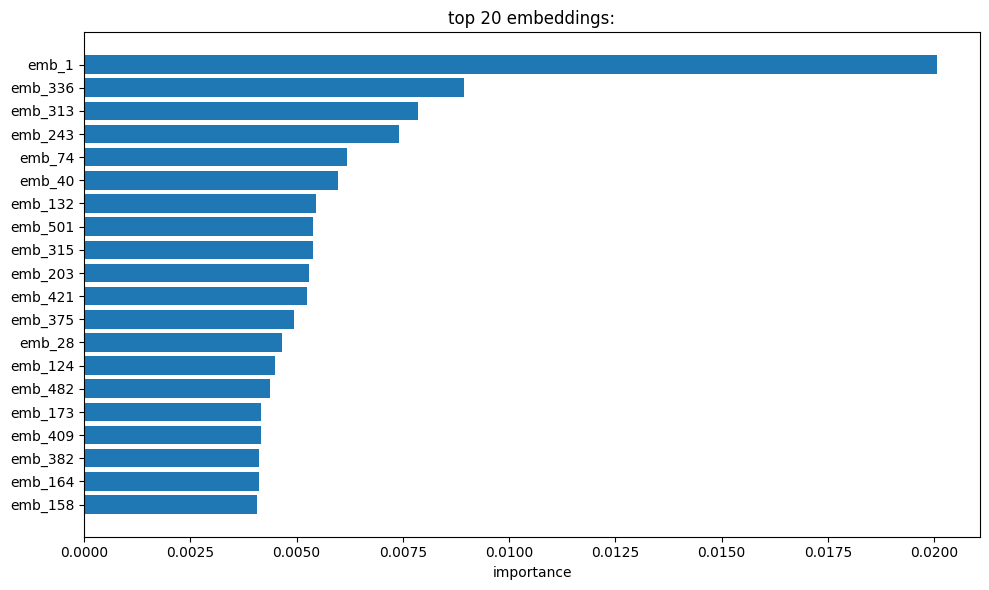

In [60]:
print("top 20 embeddings:")
print()

feature_names = [f"emb_{i}" for i in range(512)] + [
    "pred_gender_score", "pred_race_score",
    "brightness", "contrast", "saturation"
]

importances = rf.feature_importances_

feat_imp_df = (
    pd.DataFrame({'feature': feature_names, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

# count embeddings
emb_cols = [col for col in feature_names if col.startswith('emb_')]
print("total embeddings:", len(emb_cols))
print()

# top 20 features
top_20_features = feat_imp_df.head(20)

print("top 20 most important features")
print(top_20_features.to_string(index=False))
print()

visual_features = [
    "brightness", "contrast", "saturation",
    "pred_gender_score", "pred_race_score"
]

print()

plt.figure(figsize=(10, 6))
plt.barh(range(20), top_20_features['importance'].values[::-1])
plt.yticks(range(20), top_20_features['feature'].values[::-1])
plt.xlabel("importance")
plt.title("top 20 embeddings:")
plt.tight_layout()
plt.show()

In [ ]:
# although individual embedding dimensions are not interpretable, few of them dominate the feature importance distribution 
# deep neural networks encode high-level information unevenly across dimensions so some embeddings capture patterns that strongly 
# separate error vs non-error cases
# the fact that a single dimension (emb_1) contributes more than the others is therefore expected 

feature importance comparison: embeddings vs visual features

total importance of 512 embeddings: 0.9911 (99.1%)
total importance of 5 visual features: 0.0089 (0.9%)

visual features ranking:
pred_gender_score    rank 513/517   importance: 0.001673
pred_race_score      rank 514/517   importance: 0.001331
brightness           rank 515/517   importance: 0.002825
contrast             rank 516/517   importance: 0.001464
saturation           rank 517/517   importance: 0.001564



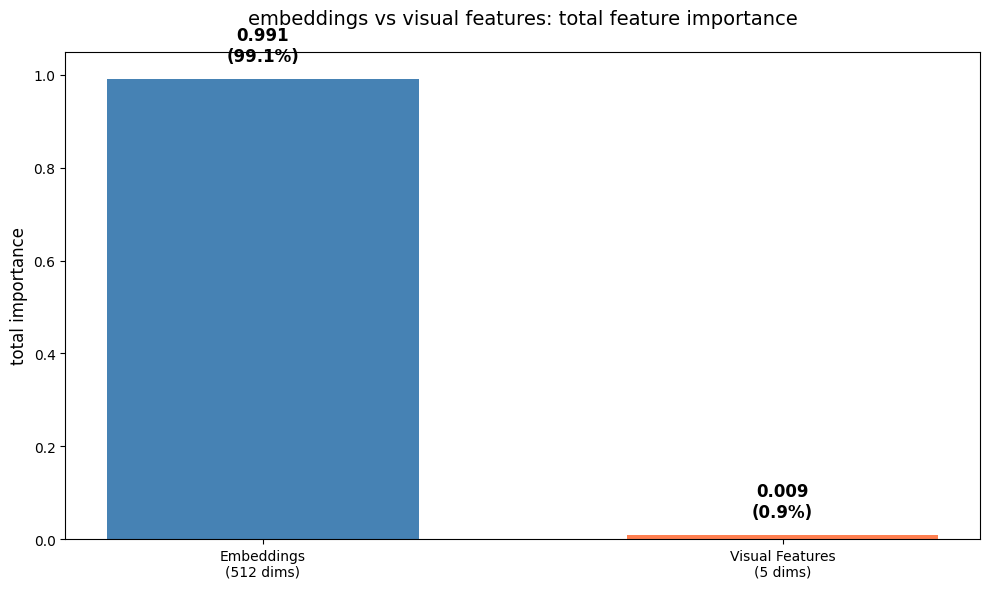

conclusion: deep embeddings capture far more predictive information than simple visual features


In [61]:
print("feature importance comparison: embeddings vs visual features")
print()

feature_names = [f"emb_{i}" for i in range(512)] + ["pred_gender_score", "pred_race_score", "brightness", "contrast", "saturation"]
importances = rf.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

emb_importance = feat_imp_df[feat_imp_df['feature'].str.startswith('emb_')]['importance'].sum()
visual_importance = feat_imp_df[~feat_imp_df['feature'].str.startswith('emb_')]['importance'].sum()

print(f"total importance of 512 embeddings: {emb_importance:.4f} ({emb_importance*100:.1f}%)")
print(f"total importance of 5 visual features: {visual_importance:.4f} ({visual_importance*100:.1f}%)")
print()

print("visual features ranking:")
visual_features = ['pred_gender_score', 'pred_race_score', 'brightness', 'contrast', 'saturation']
for feature in visual_features:
    rank = feat_imp_df[feat_imp_df['feature'] == feature].index[0] + 1
    importance = feat_imp_df[feat_imp_df['feature'] == feature]['importance'].values[0]
    print(f"{feature:20s} rank {rank:3d}/517   importance: {importance:.6f}")
print()

categories = ['Embeddings\n(512 dims)', 'Visual Features\n(5 dims)']
importance_values = [emb_importance, visual_importance]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, importance_values, color=['steelblue', 'coral'], width=0.6)
plt.ylabel('total importance', fontsize=12)
plt.title('embeddings vs visual features: total feature importance', fontsize=14, pad=20)
plt.ylim(0, 1.05)

for i, (bar, v) in enumerate(zip(bars, importance_values)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.03,
             f'{v:.3f}\n({v*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("conclusion: deep embeddings capture far more predictive information than simple visual features")